## MEAM5460 Project 2: Trim Analysis
### Nathaniel Ruhl
### Spring 2023

### Methodology

The goal of our "trim" is to determine the control inputs required to achieve a desired opertational state. Our desired operational state consists of 

1. Zeroing out longitudianal and lateral flapping, eg. $\beta_{1c}=\beta_{1s}=0$
2. Achieving a specified forward thrust ($0.05 < C_X < 0.01$)
3. Acheiving a specified rotor thrust ($0.005 < C_T < 0.1$)

In order to acheive these effects, we can make use of the following controls:

1. Input collective, $\theta_0$
2. Longitudinal and lateral cyclic pitch inputs, $\theta_{1c}$ and $\theta_{1s}$
3. Rotor disc plane tilt angle, $\alpha$
4. Total Power, which is derived from the torque, $C_Q$

The system of equations in the problem assignment attached above are highly coupled, yet well-behaved non-linear equations that can be solved numerically. For the desired operational state, in which $\beta_{1c}=\beta_{1s}=0$ and $C_X$ and $C_T$ are specified, we can defined a set of 5 equations and 5 uknowns. The uknown variables (which I refer to as "state variables" in my code) are

$$\mathbf{x} = 
\begin{pmatrix} \beta_0 \\ \theta_0 \\ \theta_{1c} \\ \theta_{1s} \\ \lambda \end{pmatrix}.$$

The non-linear system of equations can be written as $f(\mathbf{x})=0$, where

$$ f(\mathbf{x}) = 
\begin{pmatrix}
A_{11} \beta_0 - c_1 \\
A_{21} \beta_0 - c_2 \\
A_{31} \beta_0 - c_3 \\
\lambda - \lambda_{RHS} \\
C_T - C_{T,RHS}
\end{pmatrix}
$$

The entries of the 3x3 matrix $\mathbf{A}$ and the 3x1 column vector $\mathbf{c}$ are given in the project assignment (I defined the matrix equation as $\mathbf{A \beta} = \mathbf{c}$). The root $\mathbf{x}^*$ can be solved by Newton's method, for which I have used ``scipy.optimize.fsolve``.

The specifications of our articulated rotor are defined in the project assignment, and defined as global variables in ``proj2.py``. Furthermore, in this analysis, I have used a typical Locke numer of $\gamma=7$ since we do not know the moment of inertia of the aircraft. We should also note that the formulas given in the assignment assume linear airfoils, where the lift-curve slope is $c_{l_\alpha}=2\pi$.

I will discuss the results below and show snippets of my code, which can be adapted to perform further analysis.

In [93]:
import numpy as np
import importlib
import matplotlib.pyplot as plt

# local modules
import proj2
import plotter

importlib.reload(proj2)
importlib.reload(plotter)
from proj2 import calc_trims_array, plot_rotor_trim, knots2mps, sigma, calc_alpha
from plotter import plot_trim_vary_flap_frequency, plot_trim_vary_velocity, plot_rotor_disc_tilt

In [94]:
# Goal values of CT and CX when performing the trim
N_CT = 50
N_CX = 4
CT_norm_list = np.linspace(0.005, 0.01, N_CT)
CT_list = CT_norm_list*sigma
CX_list = np.linspace(0.05, 0.1, N_CX)

### Trim Analysis in Hover ($v_\infty=0$ knots, $\nu_\beta=1.0$)

The first plot below shows the rotor disc tilt in hover, which is always $\alpha=0^\circ$. The subsequent set of 6 plots, which show each of the states solved in $\mathbf{x}$, as well as $C_Q$, verus $C_T/\sigma$ show some interesting trends:
- The rotor trim in hover does not depend on $C_X$ at all, which is a good cross-check for the non-linear root-solving problem because any non-zero value of $C_X$ is incompatible with the hover condition.
- Cyclic inputs are zero for all $C_T/\sigma$.

I believe that the following trends indicate that Newton's method has found the incorrect root:
- Coning angle becomes less negative with $C_T/\sigma$.
- Input collective decreases as $C_T/\sigma$ increases. Shouldn't we need a larger collective to achieve a larger thrust?

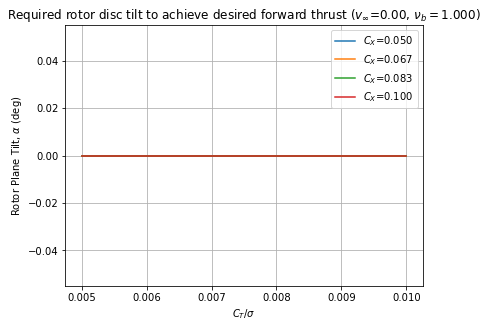

In [97]:
v_inf = knots2mps(0)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_norm_list, v_inf, nu_b)

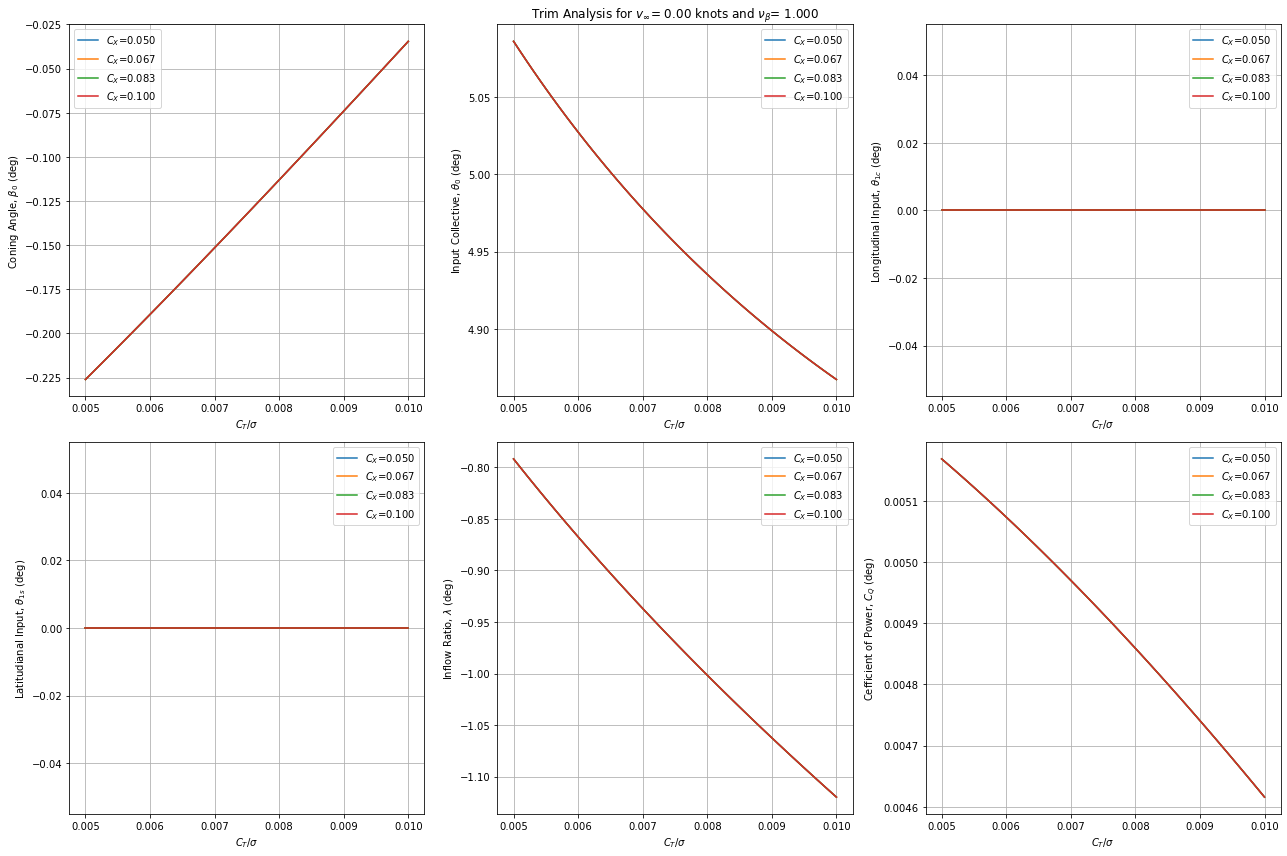

In [98]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Trim Analysis in Forward Flight ($v_\infty=25$ knots, $\nu_\beta=1.0$)

In order to achieve this speed of forward flight, the rotor disc must be oriented as shown in the plot below. Unlike in hover, the curves in the 6 subplots change for different $C_X$ values. We can see that as $C_X$ increases, all of the controls must increase in magnitude. Notably, $\theta_{1s}$ becomes more negative, while the other curves become more positive. The curves seems to be fairly linearly spaced with respect to $C_X$, which is one reason I decided to plot $C_T/\sigma$ on the x-axis and vary $C_X$ in the curves.

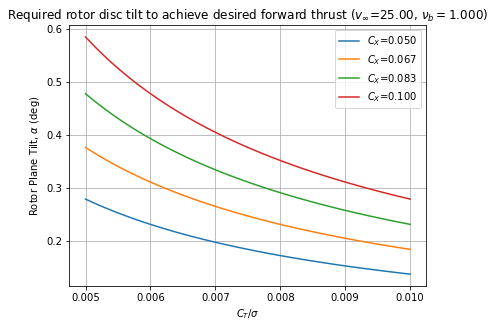

In [99]:
v_inf = knots2mps(25)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_norm_list, v_inf, nu_b)

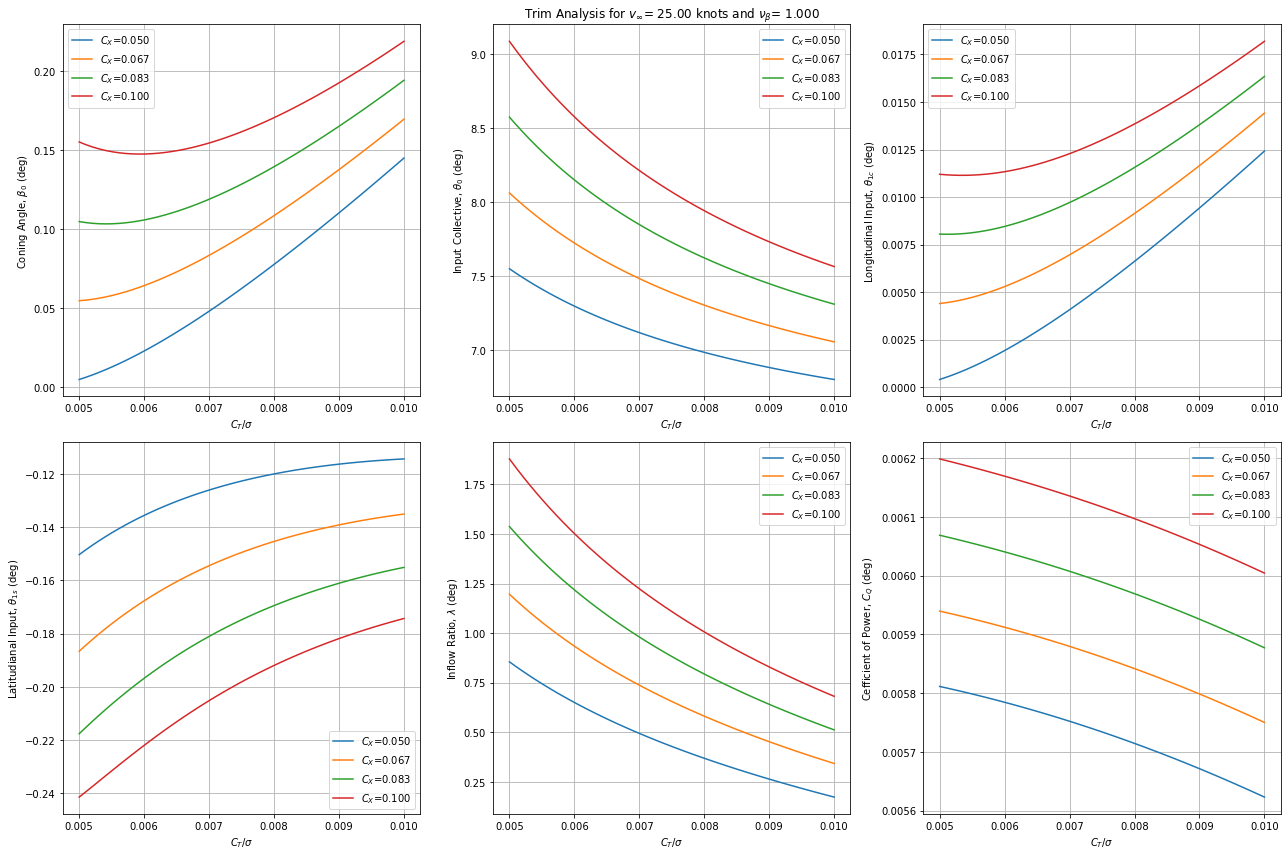

In [100]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Trim Analysis in Forward Flight ($v_\infty=33$ knots and $\nu_\beta=1$)

I chose to include $v_\infty=33$ knots because this is approximately the maximum $v_\infty$ for which $\alpha$ exists (within the range of $C_X$). We will discuss this further with the plots for $v_\infty=50$ knots. The plots of $\theta_{1c}$ and $\theta_{1s}$ below start to show interesting behavior for large values of $C_X$ and small values of $C_T$. This behavior leads up to the singularity in $\alpha$, and is discussed further below.

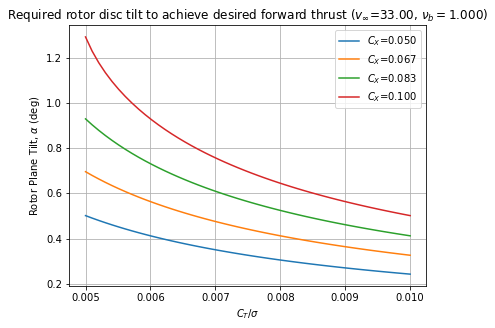

In [101]:
v_inf = knots2mps(33)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_norm_list, v_inf, nu_b)

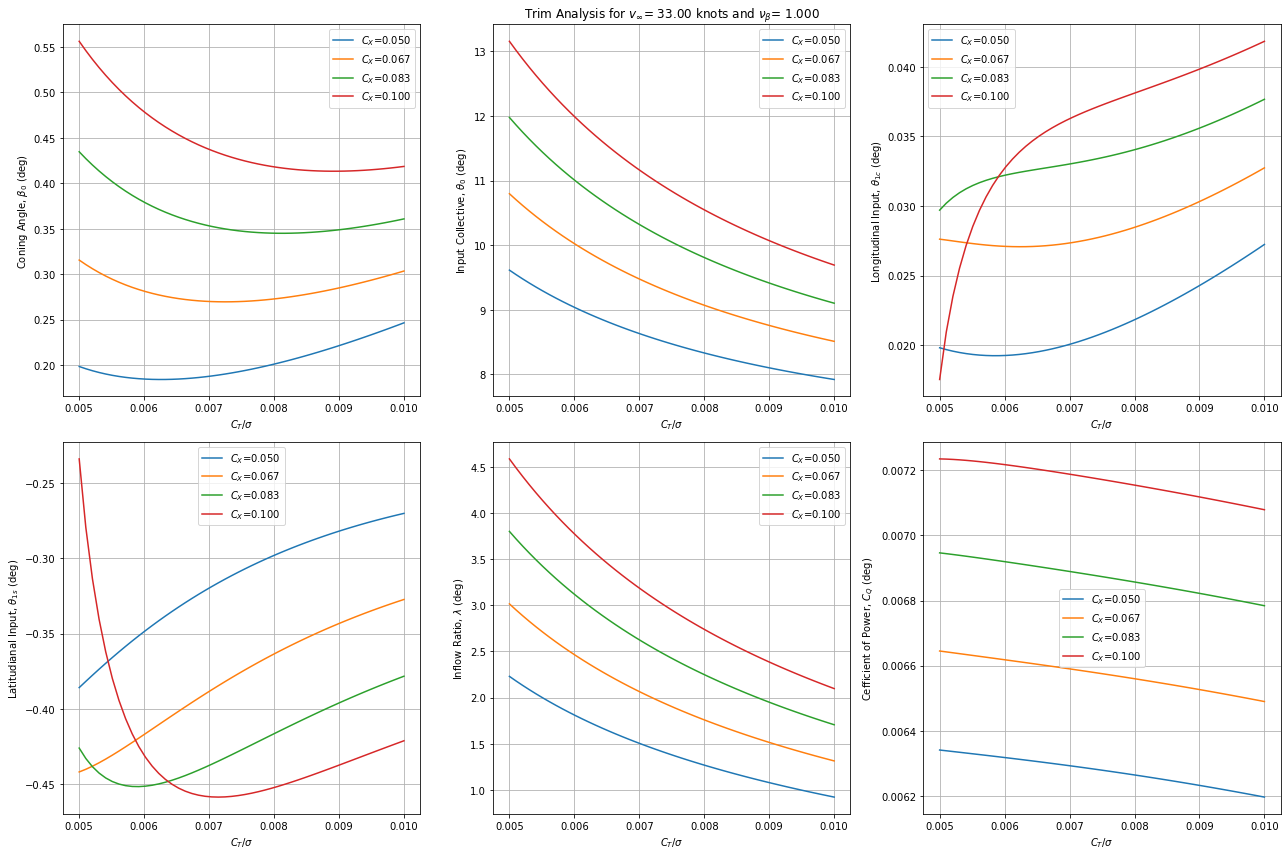

In [102]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Trim Analysis in Forward Flight ($v_\infty=50$ knots and $\nu_\beta=1$)

As can be seen in the error messages below, the $\arcsin()$ in the equation for $\alpha$ goes out of range because $$\frac{0.5C_X v^2_\infty}{C_T v^2_{tip}} > 1$$. Moreover, the plot of $\alpha$ vs $C_T/\sigma$ shows where the singularity occurs, near an angle of $\alpha = 1.4^\circ$. For a given $v_\infty$, we have a strict condition between $C_X$ and $C_T$ which determines the maximum rotor disc tilt:

$$\frac{C_X}{C_T} > \frac{v^2_{tip}}{0.5 v^2_\infty}$$.

/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))
/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))
/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))
/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))


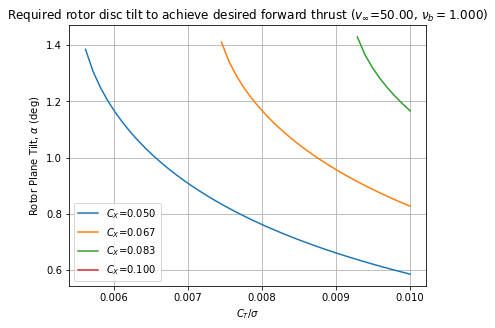

In [45]:
v_inf = knots2mps(50)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_norm_list, v_inf, nu_b)

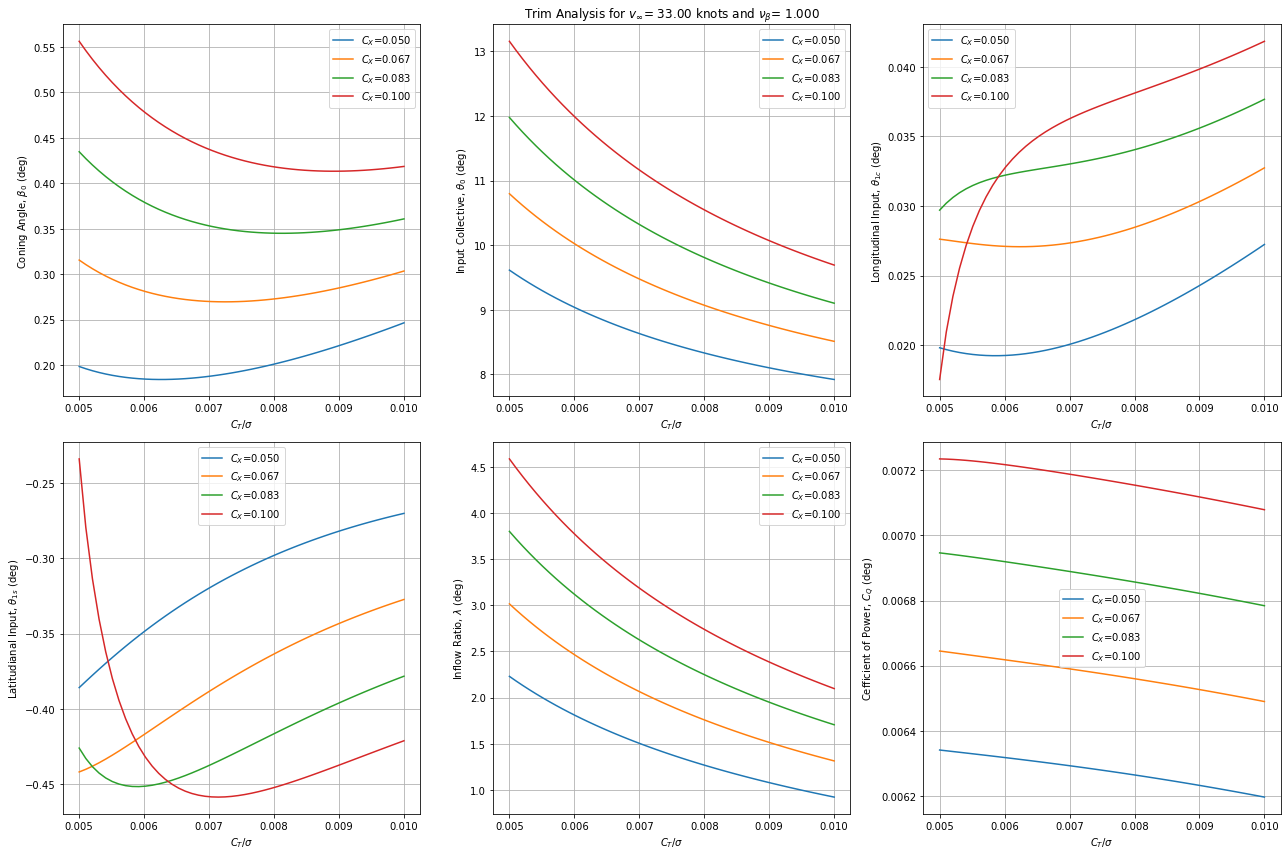

In [103]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Effect of varying non-dimensional flap frequency

In order to consider the effects of non-dimension lap frequency, $\nu_\beta$, we will consider $v_\infty=25$ knots and $C_X=0.05$. The effect of $\nu_\beta$ is strong, and the plots of $\beta_0$ and $\theta_{1c}$ do change significantly for different values of $v_\infty$ and $C_X$. Therefore, it is worthwile to consider making 3-dimensional figures or simulations for these relatioinships, but the qualitative observations made for the other 4 plots are universal. $\theta_0$, $\theta_{1s}$, $\lambda$, and $C_Q$ are independent of $\nu_\beta$. This is extremely helpful to know when designing a rotor system!

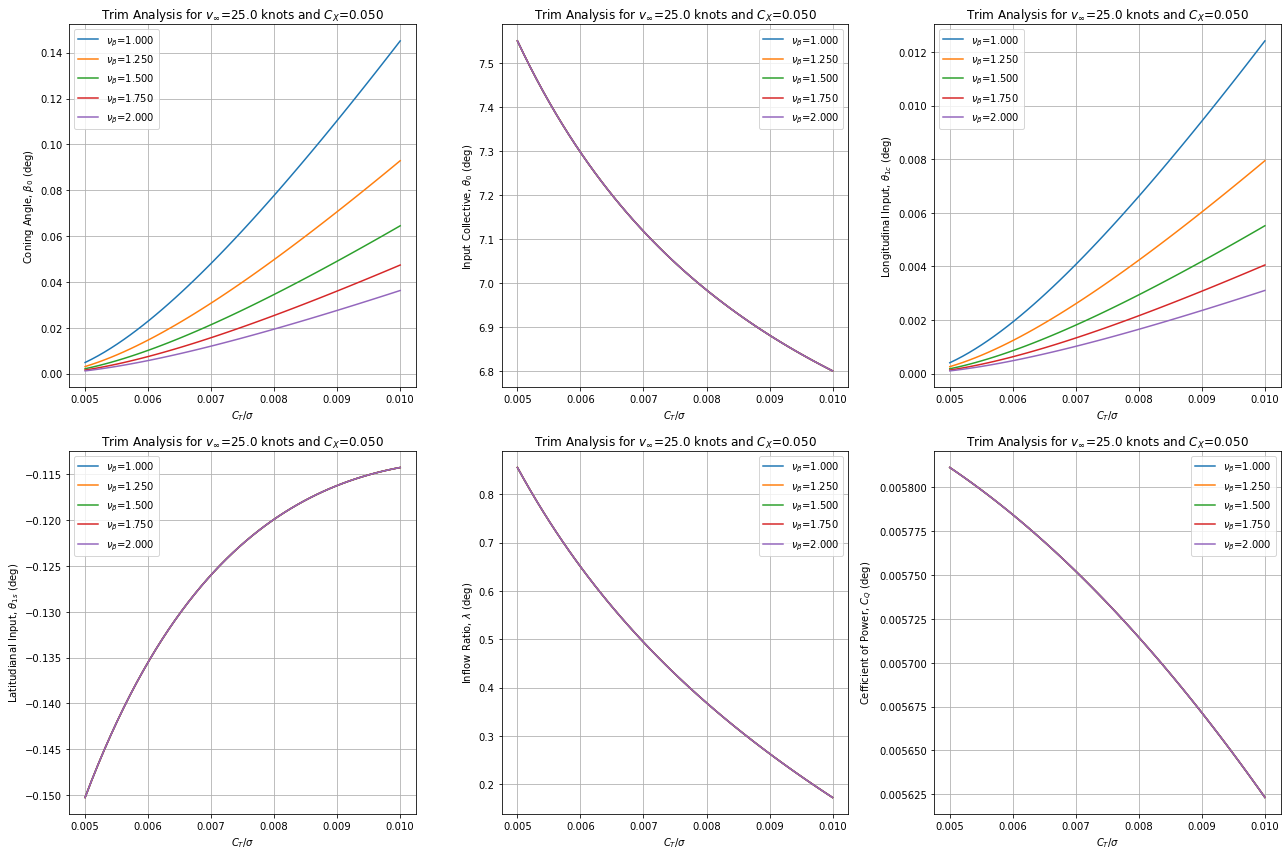

In [112]:
nu_b_list = np.linspace(1.0,2.0,5)
plotter.plot_trim_vary_flap_frequency(nu_b_list, v_inf=knots2mps(25), CX=0.05)

### Effects of Forward Flight Velocity

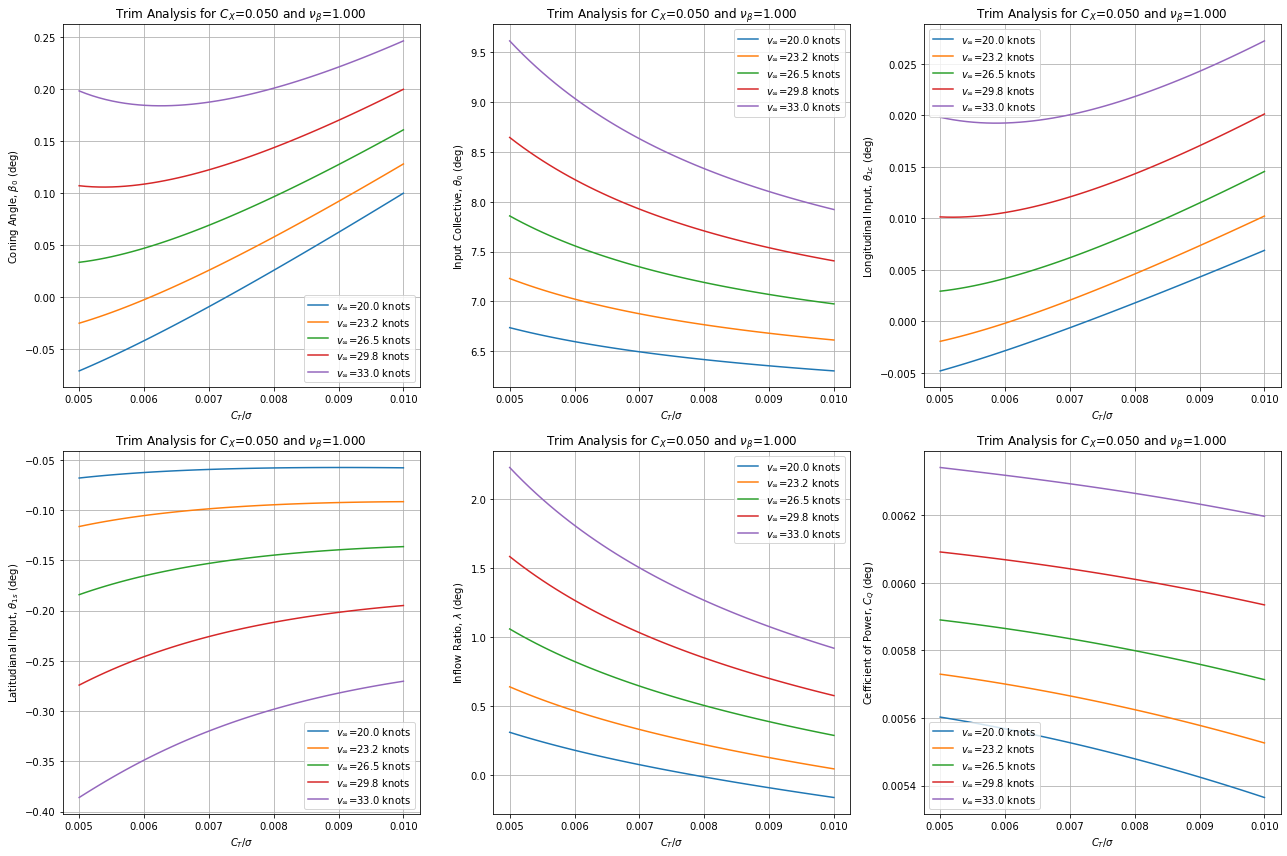

In [105]:
v_inf_list = np.linspace(knots2mps(20),knots2mps(33), 5)
plotter.plot_trim_vary_velocity(v_inf_list, CX=0.05, nu_b=1.0)

Does this make sense to hold $C_X$ constant in this scenario?